<a href="https://colab.research.google.com/github/Martinmbiro/Gradient-Boosting-with-CatBoot-for-Classification/blob/main/05%20Multiclass%20Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Multiclass Classification**  
> This is the task of classifying data that has more than two classes.

> Multiclass classification can be thought of as a combination of multiple _binary classifiers_, and there are two ways in which the problem can be approached:
+ **One vs Rest (OVR)**  
>> + A classifier is created for each possible class value, with a positive outcome for cases where the prediction is this class, and negative predictions for cases where the prediction is any other class.
+ **One vs One (OVO)**
>> + A classifier for each possible pair of classes is created.

> In both approaches, the overall model must take into account all of these predictions to determine which single category the item belongs to

> Most machine learning frameworks, including [`sklearn`]() implicitly support multiclass classification by abstracting an `OVR` algorithm, an `OVO` algorithm, or by allowing a choice of either.   
+ [`catboost`](https://catboost.ai/) and [`xgboost`](https://xgboost.readthedocs.io/en/stable/#) in particular only implement the `OVR` approach.

## Load the data
+ We've got to load the data first

In [ ]:
# import pandas, matplotlib, seaborn, specify stylesheet
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fast')

!wget https://raw.githubusercontent.com/MicrosoftDocs/mslearn-introduction-to-machine-learning/main/Data/ml-basics/penguins.csv
penguins = pd.read_csv('penguins.csv')

In [ ]:
# display dataset info
penguins.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   CulmenLength   342 non-null    float64
 1   CulmenDepth    342 non-null    float64
 2   FlipperLength  342 non-null    float64
 3   BodyMass       342 non-null    float64
 4   Species        344 non-null    int64  
dtypes: float64(4), int64(1)
memory usage: 13.6 KB


> 💡 **Info**
+ Lucky for us, all features are numeric / continuous meaning we don't have to worry about encoding categorical columns

In [ ]:
# seems there might be a few null values, let's see
penguins.isnull().sum()

,0
CulmenLength,2
CulmenDepth,2
FlipperLength,2
BodyMass,2
Species,0


In [ ]:
# Show rows for which any column might be null
penguins.loc[penguins.isnull().any(axis='columns')]
# SAME: penguins[penguins.isnull().any(axis='columns')]

,CulmenLength,CulmenDepth,FlipperLength,BodyMass,Species
3,NaN,NaN,NaN,NaN,0
271,NaN,NaN,NaN,NaN,1


In [ ]:
# dropping rows with null values, and overwrite the initial dataframe
penguins = penguins.dropna(axis='index')

In [ ]:
# check to see if rows with null values were dropped
penguins.isnull().sum()

,0
CulmenLength,0
CulmenDepth,0
FlipperLength,0
BodyMass,0
Species,0


> 💡 **Info**  

> [`Panda`](https://pandas.pydata.org/docs/index.html) methods used in the above analysis include:
+ [`info()`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.info.html#pandas.DataFrame.info) - Print a concise summary of a [`DataFrame`](https://pandas.pydata.org/docs/reference/frame.html)
+ [`sum()`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.sum.html#pandas.DataFrame.sum) - Return the sum of the values over the requested axis
+ [`any()`](https://pandas.pydata.org/docs/reference/api/pandas.Series.any.html#pandas.Series.any) - Return whether any element is True, potentially over an axis
+ [`dropna()`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.dropna.html#pandas.DataFrame.dropna) - Remove missing values

### Check for label imbalance

In [ ]:
# value count for each class
penguins['Species'].value_counts()

,count
Species,
0,151
1,123
2,68


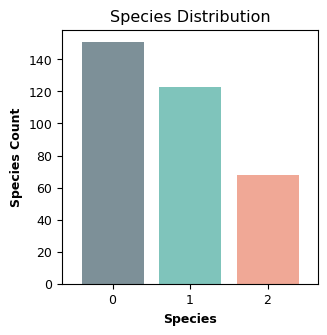

In [ ]:
'''
  sketch the distribution
'''
# specify figure and Axes
fig, ax= plt.subplots(figsize=(3.3, 3.3))

# make plot
penguins['Species'].value_counts().plot.bar(rot=0,
                                            width=0.8,
                                            color=['#264653', '#2a9d8f', '#e76f51'],
                                            alpha=0.6,
                                            ax=ax)

ax.set_ylabel('Species Count', weight='black')
ax.set_title('Species Distribution', fontsize=11.5)
ax.set_xlabel('Species', weight='black')

plt.show()

> ✋ **Disclaimer**  

> So again, we have the problem of an imbalanced dataset 💔
+ Last time, in the previous notebooks, we solved it using the _oversampling_ technique with [`SVMSMOTE`](https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SVMSMOTE.html)
+ This time round let's try _stratified sampling_ with [`train_test_split`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) `stratify` parameter when sampling, and later _oversampling_ using the [`imblearn`](https://imbalanced-learn.org/stable/index.html) library

> 📝 **Note**  
+ _Stratified sampling_ is a technique used in Machine Learning to ensure that each subset of data has the same proportion as the original dataset, which is particularly useful when dealing with imbalanced datasets, like ours.
+ However, the data is still going to be imbalanced

## Split the data

In [ ]:
# features_list
features_list = penguins.drop(columns='Species').columns

# features
X = penguins[features_list]

# label / target
y = penguins['Species']

In [ ]:
# quick info on the features dataframe
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 342 entries, 0 to 343
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   CulmenLength   342 non-null    float64
 1   CulmenDepth    342 non-null    float64
 2   FlipperLength  342 non-null    float64
 3   BodyMass       342 non-null    float64
dtypes: float64(4)
memory usage: 13.4 KB


In [ ]:
from sklearn.model_selection import train_test_split

# split into training and validation / test sets
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   random_state=42,
                                                   test_size=0.3,
                                                   stratify=y)

## Exploratory data analysis

### Feature Distribution
> To visualize how individual features are distributed, we'll use [`seaborn`](https://seaborn.pydata.org/index.html) [`histplot`](https://seaborn.pydata.org/generated/seaborn.histplot.html#seaborn.histplot)

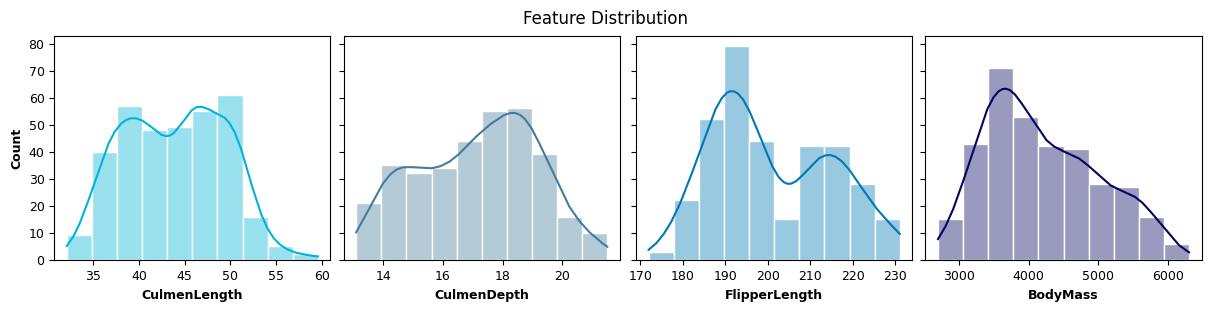

In [ ]:
# list of colors for this plot
color_list=['#00b4d8', '#457b9d', '#0077b6', '#03045e']

# specify a subplot with 1 row and 4 columns
fig, axs = plt.subplots(1, 4, figsize=(12, 3),
                        layout='constrained', sharey=True)

# use a loop to sketch the 4 plot (appreciate how concise the code is:)
for indx, col in enumerate(features_list):
  sns.histplot(data=penguins, x=col, kde=True, ax=axs[indx],
               cbar=True, color=color_list[indx], bins=10,
               alpha=0.4,
               edgecolor='#ffffff')

  axs[indx].set_xlabel(col, weight='black')

# modify the xticks
axs[0].set_yticks(range(0, 90, 10))
axs[0].set_ylabel('Count', weight='black')

# suptitle
fig.suptitle('Feature Distribution', fontsize=12)
plt.show()

> 📉 **Observation**
+ Most features seem to have somewhat of a normal distribution, though no perfect.
+ The `BodyMass` column is _right-skewed_

### Relationship between the features and label
> To visualize how individual features are distributed across the label classes, we'll use [`seaborn`](https://seaborn.pydata.org/index.html) [`boxplot`](https://seaborn.pydata.org/generated/seaborn.boxplot.html)

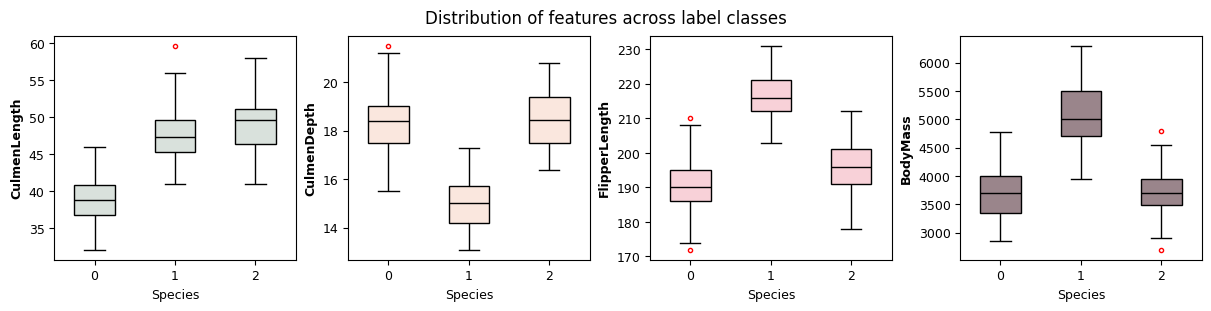

In [ ]:
# list of colors for this plot
color_list=['#d8e2dc', '#ffe5d9', '#ffcad4', '#9d8189']

# specify subplot with 1 row and 4 columns
fig, axs = plt.subplots(1, 4, figsize=(12, 3), layout='constrained')

# use a for loop to plot distribution of all features against species
for indx, col in enumerate(features_list):
  sns.boxplot(data=penguins, x='Species', y=col, width=0.5,
              flierprops={'marker': '.', 'markeredgecolor': 'red'},
              color=color_list[indx], linecolor='#000000',
              ax=axs[indx])

  axs[indx].set_ylabel(col, weight='black')

# suptitle
fig.suptitle('Distribution of features across label classes',
             fontsize=12)
plt.show()

> 📉 **Observation**
+ Although `Species` `0` and `2` `(Amelie` & `Chinstrap)` seem to have somewhat similar data profiles for `CulmenDepth`, `FlipperLength`, and `BodyMass`, the latter tend to have longer `CulmenLength`
+ Also, `Species` `1` `(Gentoo)` has particularly distinct features from the other two Species

> This means that the features are descriptive of the labels, and hence can be used to train a classification model

## Data preprocessing `pipeline`
> Here, we'll make a data pre-processing pipeline using [`scikit-learn's`](https://scikit-learn.org/stable/index.html) [`make_pipeline`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.make_pipeline.html) and [`make_colum_transformer`](https://scikit-learn.org/stable/modules/generated/sklearn.compose.make_column_transformer.html)


In [ ]:
# import necessary libraries
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

In [ ]:
# list of numerical feature indices in dataframe
num_indices = list()
for feature in features_list:
  num_indices.append(penguins.columns.get_loc(feature))

# numeric features transformer
num_transformer = make_pipeline(
    (SimpleImputer(strategy='median')), # handle null values if any
    (StandardScaler()) # scale
)

# wrap the num_transformer in a ColumnTransformer object
preprocesser = make_column_transformer(
    #(transformer, columns)
    (num_transformer, num_indices)
)

## Resampling
> ❗ **Recall**
+ This is an _imbalanced_ dataset, hence we'll have to resample it, to avoid bias in classification of under-represented classes

### Visualize imbalance in `X_test`

In [ ]:
y_train.value_counts()

,count
Species,
0,106
1,86
2,47


### Oversampling

In [ ]:
# import BorderlineSMOTE class
from imblearn.over_sampling import BorderlineSMOTE

# create a BorderlineSMOTE object
blsmote = BorderlineSMOTE(random_state=42)

# resample
Xr, yr = blsmote.fit_resample(X_train, y_train)

In [ ]:
# import SVMSMOTE class
from imblearn.over_sampling import SVMSMOTE

# create an SVMSMOTE object
svmsmote = SVMSMOTE(random_state=42)

# resample
Xr, yr = svmsmote.fit_resample(X_train, y_train)

### Visualize difference after oversampling

In [ ]:
# class distribution after oversampling
yr.value_counts().sort_index()

,count
Species,
0,106
1,106
2,106


In [ ]:
# create a DataFrame of y_train.value_counts() and yr.value_counts()
df = pd.DataFrame({'y_train' : y_train.value_counts().sort_index(),
                   'yr': yr.value_counts().sort_index()})

In [ ]:
# a peek into the DataFrame:
df

,y_train,yr
Species,,
0,106,106
1,86,106
2,47,106


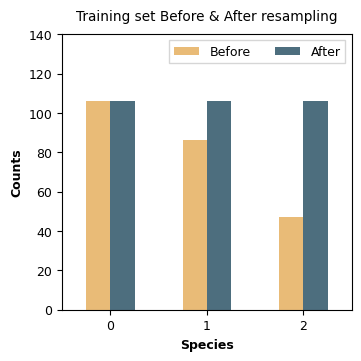

In [ ]:
'''
plot the two columns as grouped bars on the yaxis,
  and the index is automatically set as the xaxis
'''
# create subplot
fig, ax = plt.subplots(figsize=(3.5, 3.5), layout='constrained')

# make the plot
df.plot.bar(y=['y_train', 'yr'], rot=0, width=0.5,
            color=['#e09f3e', '#023047'],
            alpha=0.7,
            ax=ax)

# a few modifications
ax.set_ylabel('Counts', weight='black', fontsize=9)
ax.set_xlabel('Species', weight='black', fontsize=9)
ax.set_yticks(range(0, 145, 20))
ax.set_title('Training set Before & After resampling', fontsize=9.8,
             pad=10)

# modify lagend
plt.legend(['Before', 'After'], ncols=2, markerscale=5, fontsize=9, fancybox=False)
plt.show()

> 📝 **Note**
+ This time around, I only tried out oversampling using [`SVMSMOTE`](https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SVMSMOTE.html) and [`BorderlineSMOTE`](https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.BorderlineSMOTE.html)  
+ I went with results from [`SVMSMOTE`](https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SVMSMOTE.html) since they resulted in the better metrics

## Modelling

In [ ]:
!pip install catboost

In [ ]:
# import necessary libraries
from sklearn.pipeline import Pipeline
from catboost import CatBoostClassifier

### Train a [`CatBoostClassifier`]() model

In [ ]:
%%time
# pipeline with preprocesser + estimator
cat_model = Pipeline(steps=[
    # (name, estimator / transformer)
    ('preprocess', preprocesser), # preprocesser
    ('cbc', CatBoostClassifier(random_state=42,
                               early_stopping_rounds = 10,
                               eval_metric = 'Accuracy',
                               iterations=100)) # estimator
])

# train the model
cat_model.fit(Xr.values, yr.values,
              cbc__eval_set=(preprocesser.fit_transform(X_test.values), y_test.values),
              cbc__verbose=10)

# make predictions
y_pred = cat_model.predict(X_test.values)

Learning rate set to 0.254318
0:	learn: 0.9654088	test: 0.9708738	best: 0.9708738 (0)	total: 5ms	remaining: 495ms
10:	learn: 0.9905660	test: 0.9805825	best: 0.9805825 (1)	total: 23.8ms	remaining: 192ms
Stopped by overfitting detector  (10 iterations wait)

bestTest = 0.9805825243
bestIteration = 1

Shrink model to first 2 iterations.
CPU times: user 63.2 ms, sys: 7.92 ms, total: 71.1 ms
Wall time: 71.2 ms


> Funny how the dataset was trained with only one tree decision tree! 😹😹😹

## Evaluation

In [ ]:
# import
from sklearn.metrics import ConfusionMatrixDisplay

In [ ]:
# define function to plot confusion_matrix
def plot_confusion_matrix(y_test, y_pred):
  # specify stylesheet
  plt.style.use('fast')

  # define figure and Axes
  fig, ax = plt.subplots(figsize=(3, 3), layout='constrained')

  # plot confusion_matrix
  ConfusionMatrixDisplay.from_predictions(y_test, y_pred,
                                          cmap='Blues',
                                          colorbar=False,
                                          ax=ax)

  # move xticks and xlabel to top
  ax.xaxis.tick_top()
  ax.xaxis.set_label_position('top')

  # modify xlabel and ylabel colors
  ax.set_ylabel('Actual Labels', weight='black', color='#003262')
  ax.set_xlabel('Predicted Labels', weight='black', color='#E52B50')

  plt.show()

### Visualize `confusion_matrix` using [`ConfusionMatrixDisplay`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html)

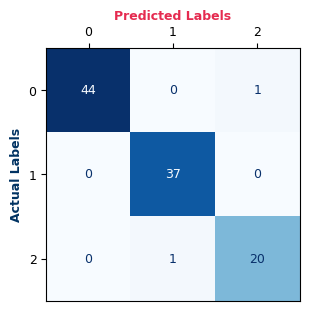

In [ ]:
plot_confusion_matrix(y_test, y_pred)

### [`classification_report`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html)



In [ ]:
# classification report
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99        45
           1       0.97      1.00      0.99        37
           2       0.95      0.95      0.95        21

    accuracy                           0.98       103
   macro avg       0.98      0.98      0.98       103
weighted avg       0.98      0.98      0.98       103



### `roc` curve (OvR Multiclass approach)

#### Explanation

> 📚 **Background**
+ In a binary classification problem, the probabilities for `[:, 1]` are usually passed to the `y_score` parameter of the [`roc_curve`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html) method since in a binary classification problem, these represent the probabilties of the +ve class, (class `1`)
+ By selecting the probabilities of each sample belonging to the positive class (class `1`), this is used to compute the `ROC` curve, which evaluates the performance of the classifier in distinguishing the positive class; `1` from the negative class; `0`
+ By focusing on `[:, 1]`, you are effectively using the classifier's output to measure its ability to correctly identify the positive class, which is essential for evaluating and comparing classifiers in binary classification tasks.

> 🔢 **Multiclass classification (OvR)**  

> Therefore, in a multiclass classification problem using the One-vs-Rest (OvR) approach for plotting `ROC` curves, we handle each class as the positive class, `1` in turn, and treat all the other classes collectively as negative, `0`
+ Get probability estimates for each class
+ Convert true labels into a binary format suitable for `ROC` curve computation (using [`scikit-learn's`](https://scikit-learn.org/stable/index.html) [`label_binarize`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.label_binarize.html) method)
+ Compute False Positive Rates; `fpr` and True Positive Rates; `tpr` for each class.
+ Calculate the ROC AUC score for each class

> 🔧 [**`label_binarize`**](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.label_binarize.html)

> This method is used to _Binarize_ labels in a _one-vs-all_ fashion
+ Offers a way to extend binary classification algorithms to the multi-class classification case
+ `label_binarize` helps in transforming label data into a format suitable for various evaluation metrics and model assessments that require binary classification input.
+ For multiclass classification problems, `label_binarize` converts a single vector of class labels into a binary format where each class is represented by a separate binary column.
+ Each row in the binary matrix corresponds to an instance in the original labels, and each column corresponds to a class. The entry is `1` if the instance belongs to that class and `0` otherwise

#### Plotting

In [ ]:
# import necessary classes and functions
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.preprocessing import label_binarize

In [ ]:
# define a function that plots multiclass ROC curve (OvR approach)
def plot_multiclass_roc_curve(model, X_test, y_test):
  # color_list
  color_list = ['#023e8a', '#ff3800', '#03c03c']

  # binarize y_test
  y_test_bin = label_binarize(y_test, classes=list(y_test.unique()))

  # predicted classes probabilities
  y_proba = cat_model.predict_proba(X_test.values)

  # average auc
  av_auc = roc_auc_score(y_true=y_test, y_score=y_proba, multi_class='ovr')

  # initialize a figure and Axes
  fig, ax = plt.subplots(figsize=(4, 4), layout='constrained')

  for i in range(y_test.nunique()):
    # get fpr, tpr, auc
    fpr, tpr, _ = roc_curve(y_true=y_test_bin[:, i] , y_score=y_proba[:, i])
    area = auc(fpr, tpr)

    # plot ROC curve for this current class as +ve and others as -v
    ax.plot(fpr, tpr, linestyle='--', linewidth=1.7,
            color=color_list[i],
            label=f'Class {i} vs Rest (AUC = {round(area, 2)})')

  # title & labels
  ax.set_title('Multiclass ROC Curve (OvR)', fontsize=10.5, weight='black')
  ax.set_ylabel('True Positive Rate')
  ax.set_xlabel('False Positive Rate')

  # include legend
  plt.legend(fontsize=8.5)
  plt.show()

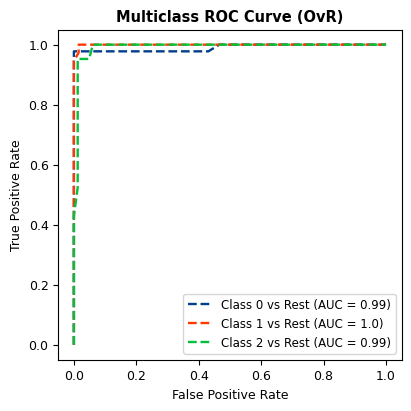

In [ ]:
# plot roc curve
plot_multiclass_roc_curve(cat_model, X_test, y_test)

### Average [`roc_auc_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html)

In [ ]:
# average auc
av_auc = roc_auc_score(y_true=y_test,
                       y_score=cat_model.predict_proba(X_test.values),
                       multi_class='ovr')

# print
print(f'Average AUC: {round(av_auc, 2)}')

Average AUC: 0.99


## Save the model
> Saving the model for inferencing

### Dump

In [ ]:
# import joblib
import joblib

filename = 'penguin_model.pkl'
joblib.dump(cat_model, filename)

['penguin_model.pkl']

### Use the model for inferencing  
> 📝 **Note**
+ The model accepts an array of feature arrays  
+ Hence, one can predict the classes of multiple patients in a single call

In [ ]:
# load model
model = joblib.load(filename)
import numpy as np

# penguin classes
penguin_classes = ['Adelie', 'Gentoo', 'Chinstrap']

In [ ]:
# An array of features
X_new = np.array([[50.4,15.3,224,5550]])

print(X_new)
print(f'Predicted class: {penguin_classes[model.predict(X_new)[0, 0]]}')

[[  50.4   15.3  224.  5550. ]]
Predicted class: Gentoo


In [ ]:
# let's try inferencing using an array of two features
X_new = np.array([[49.5,18.4,195, 3600],
         [38.2,20.1,190,3900]])

# print features, prediction
for prediction, features in zip(model.predict(X_new), X_new):
  print(features, penguin_classes[prediction[0]])

[  49.5   18.4  195.  3600. ] Chinstrap
[  38.2   20.1  190.  3900. ] Adelie


> 👋 **Last words**

> Until next time, happy _cat_boosting!_ 😹😹😹